In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import os
import zipfile

In [ ]:
# 나이 범주화 함수
def categorize_age(age):
    if age < 7:
        return 0  # 0-10세
    elif 7 <= age < 15:
        return 1  # 10대
    elif 15 <= age < 45:
        return 2  # 20-30대
    elif 45 <= age < 65:
        return 3  # 40-50대
    elif 65 <= age < 80:
        return 4  # 60-70대
    else:
        return 5  # 80대 이상

In [ ]:
# 데이터셋 압축 해제
zip_path = '/content/UTKFace.zip'  # 직접 업로드한 ZIP 파일의 경로
unzip_path = '/content/UTKFace'

if not os.path.exists(unzip_path):
    os.makedirs(unzip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("압축 해제 완료")

압축 해제 완료


In [ ]:
# UTKFace 데이터셋 경로
dataset_path = '/content/UTKFace/UTKFace'

# 데이터 로드 및 전처리 함수
def load_data(path):
    images = []
    ages = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            age = int(filename.split('_')[0])
            image = tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            ages.append(categorize_age(age))
    return np.array(images), np.array(ages)

In [ ]:
# 데이터 로드 및 정규화
X, y = load_data(dataset_path)
X = X / 255.0  # 픽셀 값을 0과 1 사이로 정규화
y = tf.keras.utils.to_categorical(y, 6)  # 원-핫 인코딩

In [ ]:
# 데이터를 훈련, 검증, 테스트 세트로 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# 데이터 증강 설정
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
# VGG16 사전 훈련된 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 레이어 동결

# 사용자 정의 층 추가
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(6, activation='softmax')(x)

In [ ]:
# 모델 컴파일
model = Model(inputs=base_model.input, outputs=output)
use_adam = True  # True이면 Adam, False이면 SGD 사용
optimizer = Adam(learning_rate=0.0001) if use_adam else SGD(learning_rate=0.00001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_generator, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
445/445 [==============================] - 150s 333ms/step - loss: 0.9191 - accuracy: 0.6725 - val_loss: 0.7267 - val_accuracy: 0.7237
Epoch 2/15
445/445 [==============================] - 145s 327ms/step - loss: 0.7723 - accuracy: 0.7105 - val_loss: 0.6625 - val_accuracy: 0.7450
Epoch 3/15
445/445 [==============================] - 144s 324ms/step - loss: 0.7359 - accuracy: 0.7260 - val_loss: 0.6570 - val_accuracy: 0.7457
Epoch 4/15
445/445 [==============================] - 146s 328ms/step - loss: 0.7110 - accuracy: 0.7298 - val_loss: 0.6553 - val_accuracy: 0.7410
Epoch 5/15
445/445 [==============================] - 145s 327ms/step - loss: 0.7010 - accuracy: 0.7356 - val_loss: 0.6640 - val_accuracy: 0.7408
Epoch 6/15
445/445 [==============================] - 145s 325ms/step - loss: 0.6771 - accuracy: 0.7415 - val_loss: 0.6261 - val_accuracy: 0.7581
Epoch 7/15
445/445 [==============================] - 146s 328ms/step - loss: 0.6739 - accuracy: 0.7432 - val_loss: 0.6468 -

In [ ]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

149/149 [==============================] - 4s 23ms/step - loss: 0.6128 - accuracy: 0.7617
Test Loss: 0.6127767562866211, Test Accuracy: 0.7617039084434509


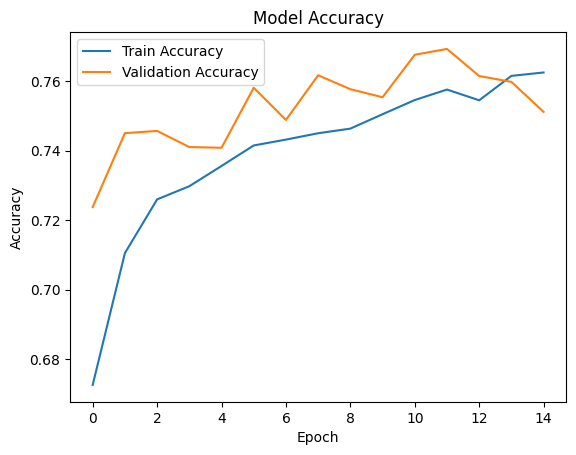

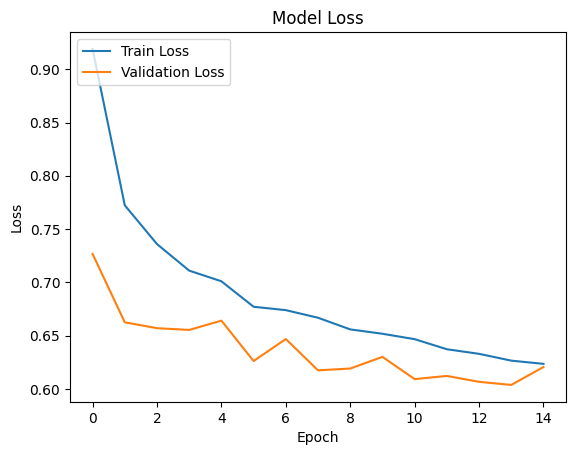

In [ ]:
# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# 모델 저장
model_save_path = '/content/age_model_gamma.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
